In [1]:
DEV_PATH = '/home/frossi/dev/'
import sys
if not DEV_PATH in sys.path:
    sys.path.append(DEV_PATH)

from mavis import *

(50, 50)


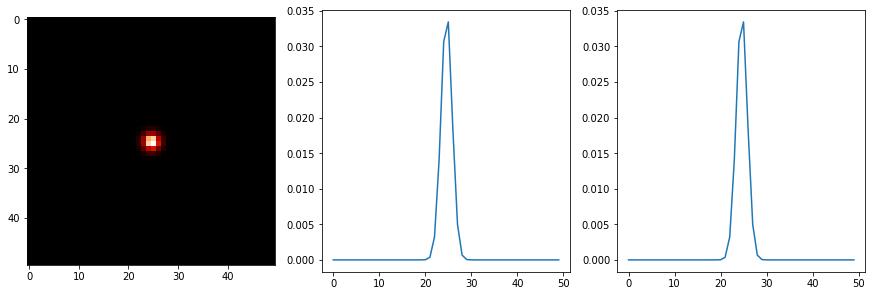

In [2]:
hdul = fits.open('MAVIS_TESTS/example_gaussian_psf.fits')
psf_data = np.asarray(hdul[0].data, np.float64)
print(psf_data.shape)
standardPsfPlot(psf_data)

In [4]:
rh1 = mf['TruncatedMeanBasic'].rhs
dd = {'i_max':30 , 'b':1.0, 't':0.5, 'nu':2.0, 'sigma_RON':sigmaRON, 'f_k': 5.0}
sexpr1 = subsParamsByName( rh1, dd )
mu_k_value = sexpr1.doit().evalf(5)
print(mu_k_value)

rh1 = mf['TruncatedVarianceBasic'].rhs
dd = {'i_max':30 , 'b':1.0, 't':0.5, 'nu':2.0, 'sigma_RON':sigmaRON, 'f_k': 5.0, "mu_k_thr":mu_k_value}
sexpr1 = subsParamsByName( rh1, dd )
sigma_k_value = sexpr1.doit().evalf(5)
print(sigma_k_value)

5.0469
5.8612


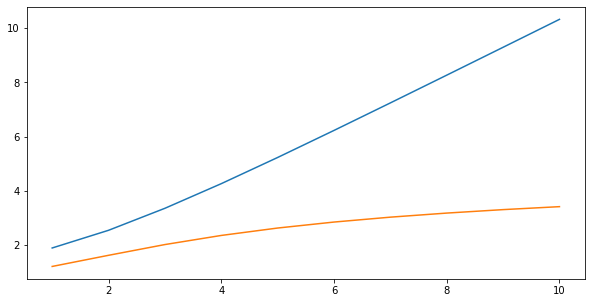

In [5]:
gridSize = 10
gridSpanArcsec = 10.0
gridSpanRad=gridSpanArcsec/radiansToArcsecs
xVarPixels = yVarPixels = 2.0
pixelSize = gridSpanRad/(gridSize-1)
imax = 32
zmin = 0.0001
zmax = 32.0
integrationPoints = 1024

mItCPU = Integrator('none', np, np.float64)
mItGPU = Integrator('none', cp, cp.float64)
mIt = mItGPU

def sampleCompute(expr0, exprK, integral, xx):
    dd0 = {'t':0.5, 'nu':2.0, 'sigma_RON':sigmaRON}
    dd1 = {'b':1.0}
    dd2 = {'F':ExcessNoiseFactor}
    expr0 = subsParamsByName( expr0, {**dd0, **dd1} )
    exprK = subsParamsByName( exprK, dd1 )
    integral = subsParamsByName( integral,  {**dd0, **dd1, **dd2} )
    aFunction = exprK * integral.function
    nn = xx.size
    aIntegral = sp.Integral(aFunction, (getSymbolByName(aFunction, 'z'), zmin, zmax), (getSymbolByName(aFunction, 'i'), 1.0, float(imax)) )
    paramAndRange = ( 'f_k', 1.0, 10.0, nn, 'linear' )
    lh = sp.Function('B')(getSymbolByName(aIntegral, 'f_k'))
    xplot1, zplot1 = mIt.IntegralEval(lh, aIntegral, [paramAndRange], [ (integrationPoints, 'linear'), (imax, 'linear')], 'rect')
    xplot1, zplot1 = cp.asnumpy(xplot1), cp.asnumpy(zplot1)
    ss, s0 = evaluateFormula(expr0, {}, ['f_k'], [xx] )
    zplot1 = zplot1*imax/max(imax-1,1) + s0
    return xplot1, zplot1

expr0M, exprKM, integralM = mf['truncatedMeanComponents']
expr0V, exprKV, integralV = mf['truncatedVarianceComponents']
xplot1, mu_ktr_array = sampleCompute(expr0M, exprKM, integralM, np.asarray(np.linspace(1.0, 10, gridSize), dtype=np.float64))
xplot2, var_ktr_array = sampleCompute(expr0V, exprKV, integralV, np.asarray(np.linspace(1.0, 10, gridSize), dtype=np.float64))
var_ktr_array = var_ktr_array - mu_ktr_array**2
sigma_ktr_array = np.sqrt(var_ktr_array.astype(np.float64))
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(xplot1[0], mu_ktr_array)
plt.plot(xplot2[0], sigma_ktr_array)
plt.show()

In [6]:
gridSize = 200
downsample_factor = 4
pixel_scale = 40 # [mas]
pixel_scale /= downsample_factor
gridSpanArcsec= pixel_scale*gridSize/1000
gridSpanRad = gridSpanArcsec/radiansToArcsecs

peakValue = NGS_flux[1]/SensorFrameRate*NGS_SR_1650[1]*4.0*np.log(2)/(np.pi*(SensingWavelength/(TelescopeDiameter/2)*radiansToArcsecs*1000/pixel_scale)**2)
peakValueNoFlux = NGS_SR_1650[1]*4.0*np.log(2)/(np.pi*(SensingWavelength/(TelescopeDiameter/2)*radiansToArcsecs*1000/pixel_scale)**2)
print(peakValue*16)

2.3406572346307253


110 2.3548200450309493 10.0
sigma: 4.671269901584105
peakValue: 0.14629107716442033
NGS_flux[1]/SensorFrameRate: 60.0
g2d sum: 20.057076379160797
g2d max: 0.14462458817669138
g2d sum: 20.057076379160797
g2d max: 1.8601496448158228
back 0.07


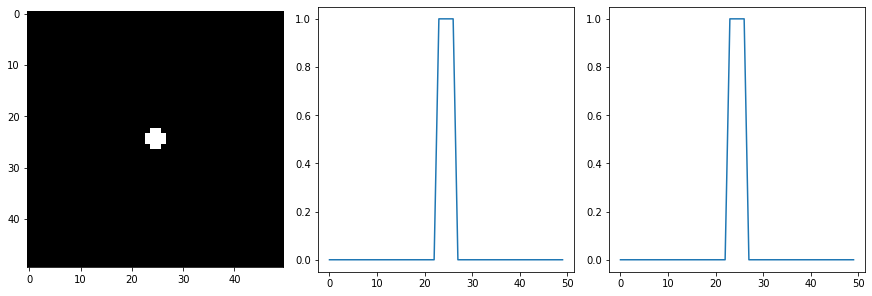

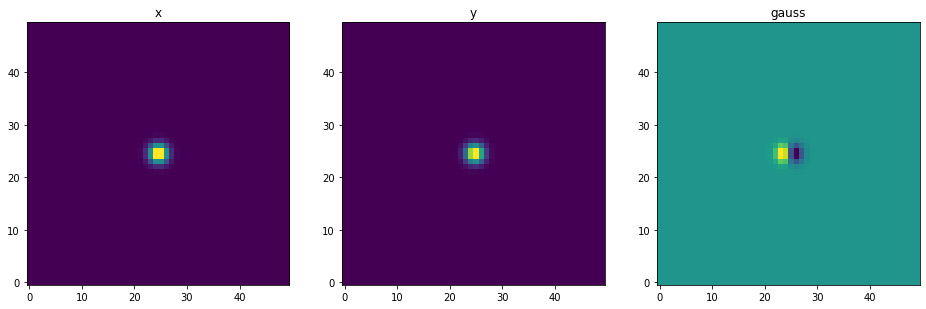

In [7]:
def simple2Dgaussian(x, y, x0=0.0, y0=0.0, sg=1.0):
    return np.exp(-((x-x0)**2)/(2*sg**2)-((y-y0)**2)/(2*sg**2) )

def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


offX = 0
offY = 0
xCoords=np.asarray(np.linspace(-gridSize/2.0+0.5, gridSize/2.0-0.5, gridSize), dtype=np.float64)
yCoords=np.asarray(np.linspace(-gridSize/2.0+0.5, gridSize/2.0-0.5, gridSize), dtype=np.float64)
xGrid, yGrid = np.meshgrid( xCoords, yCoords, sparse=False, copy=True)

asigma = NGS_FWHM_mas[1]/sigmaToFWHM/pixel_scale
print(NGS_FWHM_mas[1],sigmaToFWHM,pixel_scale)
print('sigma:', asigma)
print('peakValue:', peakValue)
print('NGS_flux[1]/SensorFrameRate:', NGS_flux[1]/SensorFrameRate)
g2d = peakValue * simple2Dgaussian( xGrid, yGrid, 0, 0, asigma)
print('g2d sum:', np.sum(g2d))
print('g2d max:', np.amax(g2d))
g2d = rebin(g2d, (50,50)) * downsample_factor**2
print('g2d sum:', np.sum(g2d))
print('g2d max:', np.amax(g2d))
p_offset = 1.0 # 1/4 di pixel a bassa risoluzione
I_k_data = peakValue * simple2Dgaussian( xGrid, yGrid, 0, 0, asigma)
I_k_prime_data = peakValue * simple2Dgaussian( xGrid, yGrid, p_offset, 0, asigma)

back = skyBackground/SensorFrameRate
print('back', back)

I_k_data = rebin(I_k_data, (50,50)) * downsample_factor**2
I_k_prime_data = rebin(I_k_prime_data, (50,50)) * downsample_factor**2

f_k_data = I_k_data + back
f_k_prime_data = I_k_prime_data + back

#g2d = scipy.ndimage.zoom(g2d, 0.25, order=5, prefilter=False) * downsample_factor**2
#f_k_data = scipy.ndimage.zoom(f_k_data, 0.25, order=1, prefilter=False) * downsample_factor**2
#f_k_prime_data = scipy.ndimage.zoom(f_k_prime_data, 0.25, order=1, prefilter=False) * downsample_factor**2

# W 
W_Mask = np.zeros(( int(gridSize/downsample_factor),int(gridSize/downsample_factor)))
ffx = np.arange(-gridSize / downsample_factor / 2, gridSize/ downsample_factor / 2, 1.0) + 0.5
(fx, fy) = np.meshgrid(ffx, ffx)
W_Mask = np.where( np.logical_or(fx**2 +fy**2 > 2**2, fx**2 + fy**2 < 0**2), 0.0, 1.0)
standardPsfPlot(W_Mask)

plt.figure(figsize=(8*2, 5))
plt.subplot(1, 3, 1)
plt.title("x")
plt.imshow(f_k_data, origin='lower', interpolation='nearest')
plt.subplot(1, 3, 2)
plt.title("y")
plt.imshow(f_k_prime_data, origin='lower', interpolation='nearest')
plt.subplot(1, 3, 3)
plt.title("gauss")
plt.imshow(f_k_data-f_k_prime_data, origin='lower', interpolation='nearest')

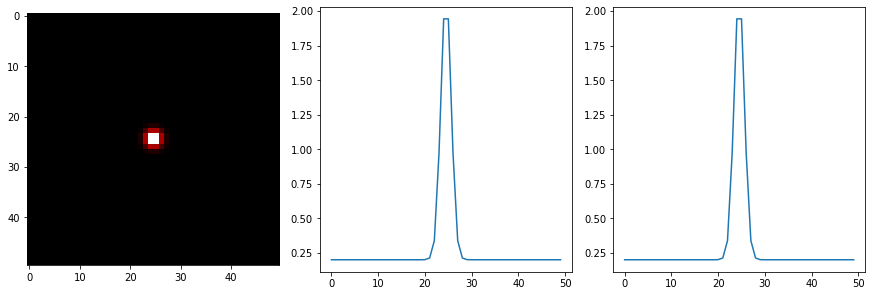

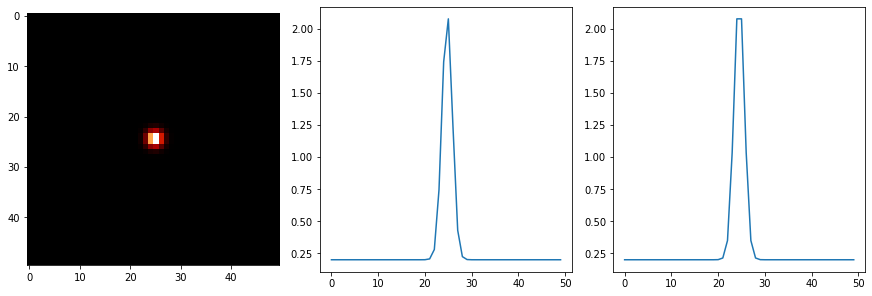

mu0 0.0
mu1 0.12594499641192117
mu1 1.1534063721158489e-16


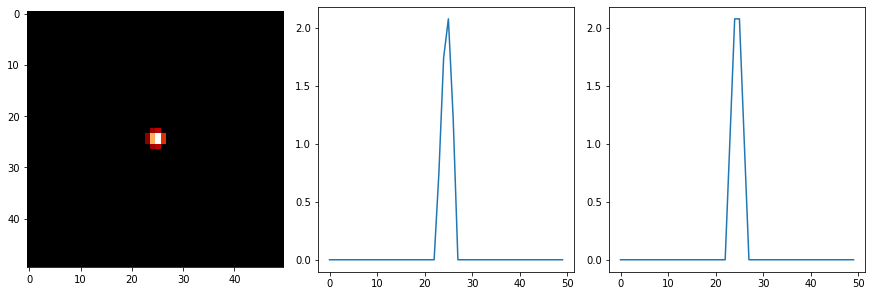

var1 0.07535821689082382
var1 0.07535821689082382


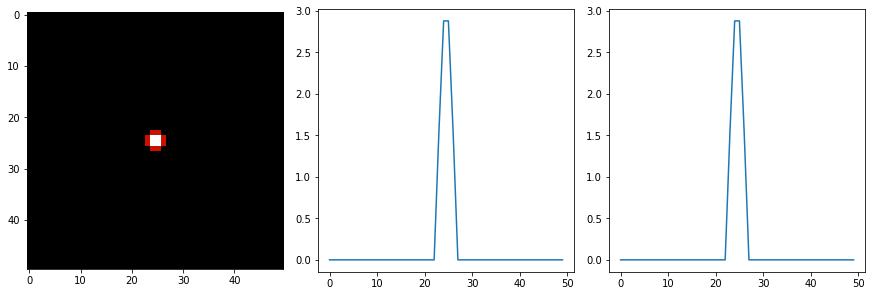

In [8]:
gridSize = 50
downsample_factor = 1
pixel_scale = 40 # [mas]
pixel_scale /= downsample_factor
gridSpanArcsec= pixel_scale*gridSize/1000
gridSpanRad = gridSpanArcsec/radiansToArcsecs

imax = 30
#zmin = 0.0001
zmin = 0.03
zmax = 30.0
integrationPoints = 1000

def sampleCompute2D(expr0, exprK, integral, gaussianPointsM):
    gaussianPoints = gaussianPointsM.reshape(gridSize*gridSize)
    dd0 = {'t':ThresholdWCoG, 'nu':NewValueThrPix, 'sigma_RON':sigmaRON}
    dd1 = {'b':Dark/SensorFrameRate}
    dd2 = {'F':ExcessNoiseFactor}
    dd3 = {'':None}
    expr0 = subsParamsByName( expr0, {**dd0, **dd1, **dd3} )
    exprK = subsParamsByName( exprK, {**dd1, **dd3} )
    integral = subsParamsByName( integral,  {**dd0, **dd1, **dd2} )
    aFunction = exprK * integral.function
    aIntegral = sp.Integral(aFunction, (getSymbolByName(aFunction, 'z'), zmin, zmax), (getSymbolByName(aFunction, 'i'), 1.0, float(imax)) )
    paramsAndRanges = [( 'f_k', gaussianPoints, 0.0, 0.0, 'provided' )]
    lh = sp.Function('B')(getSymbolByName(aFunction, 'f_k'))
    xplot1, zplot1 = mIt.IntegralEval(lh, aIntegral, paramsAndRanges, [ (integrationPoints, 'linear'), (imax, 'linear')], 'rect')
    ssx, s0 = mIt.functionEval(expr0, paramsAndRanges )
    zplot1 = zplot1*imax/max(imax-1,1) + s0
    zplot1 = zplot1.reshape((gridSize,gridSize))
    return xplot1, zplot1

def meanVarSigma(gaussianPoints):
    expr0M, exprKM, integralM = mf['truncatedMeanComponents']
    expr0V, exprKV, integralV = mf['truncatedVarianceComponents']
    xplot1, mu_ktr_array = sampleCompute2D(expr0M, exprKM, integralM, gaussianPoints)
    xplot2, var_ktr_array = sampleCompute2D(expr0V, exprKV, integralV, gaussianPoints)
    var_ktr_array = var_ktr_array - mu_ktr_array**2
    sigma_ktr_array = np.sqrt(var_ktr_array.astype(np.float64))
    return mu_ktr_array, var_ktr_array, sigma_ktr_array

mu_ktr_array, var_ktr_array, sigma_ktr_array = meanVarSigma(f_k_data)
mu_ktr_prime_array, var_ktr_prime_array, sigma_ktr_prime_array = meanVarSigma(f_k_prime_data)
standardPsfPlot(mu_ktr_array)
standardPsfPlot(mu_ktr_prime_array)
masked_mu0 = W_Mask*mu_ktr_array
print('mu0', np.sum(masked_mu0*fx)/np.sum(masked_mu0))
masked_mu = W_Mask*mu_ktr_prime_array
masked_sigma = W_Mask*W_Mask*var_ktr_array
print('mu1', np.sum(masked_mu*fx)/np.sum(masked_mu) )
print('mu1', np.sum(masked_mu*fy)/np.sum(masked_mu) )
standardPsfPlot(masked_mu)
print('var1', np.sum(masked_sigma*fx*fx)/(np.sum(masked_mu0)**2) )
print('var1', np.sum(masked_sigma*fy*fy)/(np.sum(masked_mu0)**2) )
standardPsfPlot(masked_sigma)

In [9]:
def simple2DgaussianS():
    x_a, y_a = sp.symbols('x_a y_a', real=True)
    x_aM, y_aM = sp.symbols('x_aM y_aM', real=True)
    sigma_xa, sigma_ya = sp.symbols('sigma_xa sigma_ya', real=True)
    return sp.exp(-((x_a-x_aM)**2)/(2*sigma_xa**2)-((y_a-y_aM)**2)/(2*sigma_ya**2) )

def sampleCompute2D(expr0, exprK, integral, inGaussian):
    dd0 = {'t':ThresholdWCoG, 'nu':NewValueThrPix, 'sigma_RON':sigmaRON}
    dd1 = {'b':Dark/SensorFrameRate}
    dd2 = {'F':ExcessNoiseFactor}
    dd3 = {'f_k':inGaussian}
    expr0 = subsParamsByName( expr0, {**dd0, **dd1, **dd3} )
    exprK = subsParamsByName( exprK, {**dd1, **dd3} )
    integral = subsParamsByName( integral,  {**dd0, **dd1, **dd2} )
    aFunction = exprK * integral.function
    aIntegral = sp.Integral(aFunction, (getSymbolByName(aFunction, 'z'), zmin, zmax), (getSymbolByName(aFunction, 'i'), 1.0, float(imax)) )
    display(aIntegral)
    paramsAndRanges = [( 'x_a', -gridSize/2.0+0.5, gridSize/2.0-0.5, gridSize, 'linear' ), ( 'y_a', -gridSize/2.0+0.5, gridSize/2.0-0.5, gridSize, 'linear' )]
    lh = sp.Function('B')(getSymbolByName(inGaussian, 'x_a'), getSymbolByName(inGaussian, 'y_a'))
    xplot1, zplot1 = mIt.IntegralEval(lh, aIntegral, paramsAndRanges, [ (integrationPoints, 'linear'), (imax, 'linear')], 'rect')
    xCoords=np.asarray(np.linspace(-gridSize/2.0+0.5, gridSize/2.0-0.5, gridSize), dtype=np.float64)
    yCoords=np.asarray(np.linspace(-gridSize/2.0+0.5, gridSize/2.0-0.5, gridSize), dtype=np.float64)
    ssx, ssy, s0 = evaluateFormula(expr0, {}, ['x_a', 'y_a'], [xCoords, yCoords] )
    zplot1 = zplot1*imax/max(imax-1,1) + s0
    return xplot1, zplot1

# fare il rebin qui
#mu_ktr_array = congrid(mu_ktr_array, (50, 50)) * downsample_factor**2
#var_ktr_array = congrid(var_ktr_array, (50, 50))* downsample_factor**2
#sigma_ktr_array = congrid(sigma_ktr_array, (50, 50))* downsample_factor**2
#mu_ktr_prime_array = congrid(mu_ktr_prime_array, (50, 50))* downsample_factor**2
#var_ktr_prime_array = congrid(var_ktr_prime_array, (50, 50))* downsample_factor**2
#sigma_ktr_prime_array = congrid(sigma_ktr_prime_array, (50, 50))* downsample_factor**2


In [10]:
expr0, exprK, integral = mf['truncatedMeanComponents']

dd0 = {'t':ThresholdWCoG, 'nu':NewValueThrPix, 'sigma_RON':sigmaRON}
dd1 = {'b':Dark/SensorFrameRate}
dd2 = {'F':ExcessNoiseFactor}
expr0 = subsParamsByName( expr0, {**dd0, **dd1} )
exprK = subsParamsByName( exprK, dd1 )
integral = subsParamsByName( integral,  {**dd0, **dd1, **dd2} )
expr0 = subsParamsByName( expr0, {'f_k':1.0} )
exprK = subsParamsByName( exprK, {'f_k':1.0} )

s0 = expr0.evalf()
print(s0)

for ivalue in range(1,20+1,1):
    exprKi = subsParamsByName(exprK, {'i':ivalue})
    integralI = subsParamsByName(integral, {'i':ivalue, 'z_max':30.0})
    s1 = exprKi.evalf(10) * integralI.evalf(10)
    s0 += s1
    print(ivalue, s0)

0.0592112421076572
1 0.413667980611016
2 0.791585962088383
3 0.993781741086813
4 1.06558704757702
5 1.08467339756356
6 1.08872789461946
7 1.08944522271317
8 1.08955396407066
9 1.08956838439812
10 1.08957008393211
11 1.08957026418157
12 1.08957028155900
13 1.08957028309460
14 1.08957028321985
15 1.08957028322934
16 1.08957028323001
17 1.08957028323005
18 1.08957028323005
19 1.08957028323005
20 1.08957028323005


In [11]:
var_k = sp.symbols('sigma^2_k\,thr')
mu_k = sp.symbols('mu_k\,thr')

x = sp.symbols('x', real=True)
i = sp.symbols('i', integer=True, positive=True)
# 8. Fattore di excess noise (dato) (F) : 1.0 (formule semplificate , per F>1 formule complete)
F = sp.symbols('F', real=True)
# f_k = I_k + back, vedi appedice D : back: 0.0
f_k = sp.symbols('f_k', real=True)
# 7. Dark Current (uguale per ogni pixel, dato) (b) : 0.0
b = sp.symbols('b', real=True)
# 9. fattore Threshold (dato) (t) : 0.0
t = sp.symbols('t', real=True)
# 10. valore associato al sotto threshold (dato) (nu) : 0.0
nu = sp.symbols('nu', real=True)
# 5. RON per pixel (uguale per ogni pixel, dato) (sigma_RON) : 0.5, var: 0.25
sigma_ron = sp.symbols('sigma_RON', real=True)

phi = sp.Function('phi')(x)
Phi = sp.Function('Phi')(x)
K_i = sp.Function('K')(i)

with sp.evaluate(False):
    expr_phi = (sp.S(1)/sp.sqrt(sp.S(2)*sp.pi)) * sp.exp( - x**2 / 2) 
    expr_Phi = (sp.S(1)/sp.S(2)) * (1+sp.erf(x/sp.sqrt(sp.S(2)))) 
    expr_K_i = sp.exp(-(f_k+b)) * (f_k+b) ** i / sp.factorial(i)

# Visualization of the formulas 
display( sp.Eq( phi, expr_phi ) )
display( sp.Eq( Phi, expr_Phi ) )
display( sp.Eq( K_i, expr_K_i ) )
f1 = phi.subs({x: (t-(i-b))/sigma_ron})
f2 = Phi.subs({x: (i-b-t)/sigma_ron})
f3 = Phi.subs({x: (t-(i-b))/sigma_ron})
fK = K_i
i_max = sp.oo
sexpr1 = sp.Sum(fK * ( sigma_ron * f1  + (i-b) * f2 + nu * f3 ) , (i, 0, i_max))
sexpr2 = sp.Sum(fK * ( sigma_ron * (t+i-b) * f1 + (sigma_ron**2 + (i-b)**2) * f2 + nu**2 * f3 ) , (i, 0, i_max)) - mu_k**2
display(sp.Eq(mu_k,sexpr1))
display(sp.Eq(var_k,sexpr2))

z = sp.symbols('z', real=True, positive=True)
G = sp.Function('G')(z, i)

expr_G = z ** (i/(F-1) -1 )  * sp.exp(-z/(F-1)) / ( (F-1)**(i/(F-1)) *  sp.gamma(i/(F-1)) )
display( sp.Eq( G, expr_G ) )

f1 = phi.subs({x: (t+b)/sigma_ron})
f2 = Phi.subs({x: -(t+b)/sigma_ron})
f3 = Phi.subs({x: (t+b)/sigma_ron})
f4 = phi.subs({x: (t-(z-b))/sigma_ron})
f5 = Phi.subs({x: (z-b-t)/sigma_ron})
f6 = Phi.subs({x: (t-(z-b))/sigma_ron})
GG = G
fK = K_i
i_max = sp.oo
expr10 = sigma_ron * f1  - b * f2 + nu * f3
integrand_1 = GG * ( sigma_ron * f4 + (z-b) * f5 + nu * f6 )
expr1 =  sp.exp(-(f_k+b)) * expr10 + sp.Sum(fK * sp.Integral( integrand_1, (z, 0, sp.oo)) , (i, 1, i_max))
expr20 = sigma_ron * (t-b) * f1 + (sigma_ron**2 + b**2) * f2 + nu**2 * f3
integrand_2 = GG * (sigma_ron * (t+z-b) * f4 + (sigma_ron**2 + (z-b)**2) * f5 + nu**2 * f6)
expr2 = sp.exp(-(f_k+b)) * expr20 + sp.Sum(fK * sp.Integral( integrand_2, (z, 0, sp.oo)) , (i, 1, i_max)) - mu_k**2
display(sp.Eq(mu_k,expr1))
display(sp.Eq(var_k,expr2))


Eq(phi(x), exp((-x**2)/2)/sqrt(2*pi))

Eq(Phi(x), (erf(x/sqrt(2)) + 1)/2)

Eq(K(i), ((b + f_k)**i*exp(-b - f_k))/factorial(i))

Eq(mu_k,thr, Sum((nu*Phi((b - i + t)/sigma_RON) + sigma_RON*phi((b - i + t)/sigma_RON) + (-b + i)*Phi((-b + i - t)/sigma_RON))*K(i), (i, 0, oo)))

Eq(sigma^2_k,thr, -mu_k,thr**2 + Sum((nu**2*Phi((b - i + t)/sigma_RON) + sigma_RON*(-b + i + t)*phi((b - i + t)/sigma_RON) + (sigma_RON**2 + (-b + i)**2)*Phi((-b + i - t)/sigma_RON))*K(i), (i, 0, oo)))

Eq(G(z, i), z**(i/(F - 1) - 1)*(F - 1)**(-i/(F - 1))*exp(-z/(F - 1))/gamma(i/(F - 1)))

Eq(mu_k,thr, (-b*Phi((-b - t)/sigma_RON) + nu*Phi((b + t)/sigma_RON) + sigma_RON*phi((b + t)/sigma_RON))*exp(-b - f_k) + Sum(K(i)*Integral((nu*Phi((b + t - z)/sigma_RON) + sigma_RON*phi((b + t - z)/sigma_RON) + (-b + z)*Phi((-b - t + z)/sigma_RON))*G(z, i), (z, 0, oo)), (i, 1, oo)))

Eq(sigma^2_k,thr, -mu_k,thr**2 + (nu**2*Phi((b + t)/sigma_RON) + sigma_RON*(-b + t)*phi((b + t)/sigma_RON) + (b**2 + sigma_RON**2)*Phi((-b - t)/sigma_RON))*exp(-b - f_k) + Sum(K(i)*Integral((nu**2*Phi((b + t - z)/sigma_RON) + sigma_RON*(-b + t + z)*phi((b + t - z)/sigma_RON) + (sigma_RON**2 + (-b + z)**2)*Phi((-b - t + z)/sigma_RON))*G(z, i), (z, 0, oo)), (i, 1, oo)))

In [12]:
# Inputs: 
# 1. vettore di posizioni (x,y) dei pixel x_k
# 2. vettore di pesi scalari dei pixel w_k (per ora solo 0 oppure 1...)
# 3. vettore di flussi I_k su ogni pixel per lo spot
# 4. vettore di flussi I_k' su ogni pixel per lo spot shiftato di p_offset (i.e. 1/4) di pixel
# nota I_k viene calcolato considerando un modello gaussiano 2d di FWHM=n pixel (ad esenpio 2) (ricavi varianza)
# 5. RON per pixel (uguale per ogni pixel, dato) (sigma_RON) : 0.0
# 6. Valore di background (uguale per ogni pixel, dato) (back) : 0.0
# 7. Dark Current (uguale per ogni pixel, dato) (b) : 0.0
# 8. Fattore di excess noise (dato) (F) : 1.0
# 9. valore Threshold (dato) (t) : 0.0
# 10. valore associato a sotto*threshold (dato) (nu) : 0.0
# Calcolo intermedio grosso
# Calcolo mu_ktr, sigma_ktr, formulone in appendice D, dove:
# f_k = I_k + back, vedi appedice D
# Output:
# Due numeri:
# 1. Varianza della slope (si calcola solo per x e si assume uguale per y) (prima formula pag 26)
#    dove mu e sigma sono calcolati con I_k
# Ripeto il calcolo della mu' con I_k' per calcolare il bias
# 2. Bias Factor = mu' / p_offset

#    dd0 = {'t':0.5, 'nu':2.0, 'sigma_RON':sigmaRON}
#    dd1 = {'b':1.0}
